Saving img.jpg to img (1).jpg
Degraded: PSNR=24.19 dB, SSIM=0.5152
Inverse filter: PSNR=4.78 dB, SSIM=0.0029
Wiener filter: PSNR=27.22 dB, SSIM=0.6881


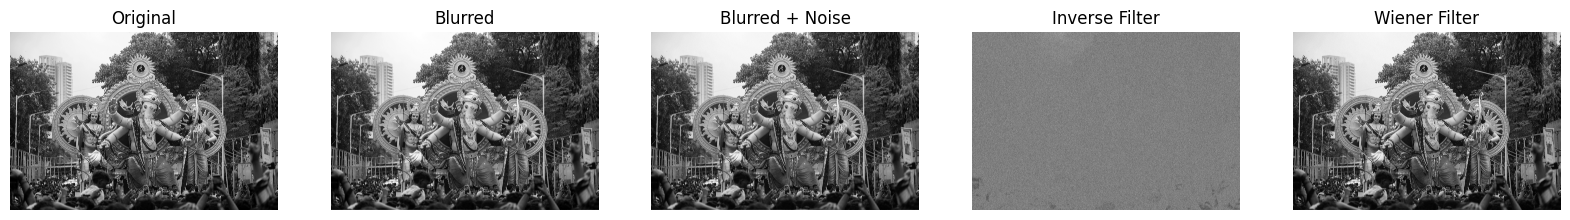

In [2]:
# --- Google Colab Compatible Code ---

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, metrics
from scipy.signal import fftconvolve
from numpy.fft import fft2, ifft2
import os

# For uploading image in Colab
from google.colab import files

# Upload your image
uploaded = files.upload()

# Change filename accordingly
img = io.imread("img.jpg")

# If image has 4 channels (RGBA), drop alpha
if img.ndim == 3 and img.shape[2] == 4:
    img = img[:, :, :3]

# Convert to grayscale if needed
if img.ndim == 3:
    img = color.rgb2gray(img)

# Normalize to [0,1]
img = (img - img.min()) / (img.max() - img.min())

# --- Helper functions ---

def gaussian_kernel(size=25, sigma=3):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def psf_pad(psf, shape):
    pad = np.zeros(shape)
    psf_shape = psf.shape
    pad[:psf_shape[0], :psf_shape[1]] = psf
    for axis, axis_size in enumerate(psf_shape):
        pad = np.roll(pad, -axis_size//2, axis=axis)
    return pad

def add_gaussian_noise(image, sigma):
    noisy = image + np.random.normal(0, sigma, image.shape)
    return np.clip(noisy, 0, 1)

def inverse_filter(blurred_noisy, H, eps=1e-3):
    G = fft2(blurred_noisy)
    H_abs = np.abs(H)
    H_safe = np.where(H_abs < eps, eps, H)
    F_hat = G / H_safe
    f_est = np.real(ifft2(F_hat))
    return np.clip(f_est, 0, 1)

def wiener_filter(blurred_noisy, H, K):
    G = fft2(blurred_noisy)
    H_conj = np.conj(H)
    denom = (np.abs(H)**2 + K)
    W = H_conj / denom
    F_hat = W * G
    f_est = np.real(ifft2(F_hat))
    return np.clip(f_est, 0, 1)

def compute_metrics(ref, test):
    psnr = metrics.peak_signal_noise_ratio(ref, test, data_range=1.0)
    ssim = metrics.structural_similarity(ref, test, data_range=1.0)
    mse = metrics.mean_squared_error(ref, test)
    return psnr, ssim, mse

# --- Processing ---

# Create PSF (Gaussian blur) and blur the image
psf = gaussian_kernel(size=25, sigma=3)
psf_p = psf_pad(psf, img.shape)
img_blurred = np.real(ifft2(fft2(img) * fft2(psf_p)))
img_blurred = np.clip(img_blurred, 0, 1)

# Add Gaussian noise
noise_sigma = 0.03
img_degraded = add_gaussian_noise(img_blurred, sigma=noise_sigma)

# Compute transfer function H
H = fft2(psf_p)

# Apply Inverse filter
inv_restored = inverse_filter(img_degraded, H)

# Apply Wiener filter
noise_var = noise_sigma**2
signal_var = np.var(img)
K = noise_var / (signal_var + 1e-12)
wiener_restored = wiener_filter(img_degraded, H, K)

# Metrics
metrics_degraded = compute_metrics(img, img_degraded)
metrics_inv = compute_metrics(img, inv_restored)
metrics_wiener = compute_metrics(img, wiener_restored)

print("Degraded: PSNR=%.2f dB, SSIM=%.4f" % (metrics_degraded[0], metrics_degraded[1]))
print("Inverse filter: PSNR=%.2f dB, SSIM=%.4f" % (metrics_inv[0], metrics_inv[1]))
print("Wiener filter: PSNR=%.2f dB, SSIM=%.4f" % (metrics_wiener[0], metrics_wiener[1]))

# --- Show Images ---
fig, axs = plt.subplots(1,5, figsize=(20,5))
axs[0].imshow(img, cmap='gray'); axs[0].set_title("Original"); axs[0].axis('off')
axs[1].imshow(img_blurred, cmap='gray'); axs[1].set_title("Blurred"); axs[1].axis('off')
axs[2].imshow(img_degraded, cmap='gray'); axs[2].set_title("Blurred + Noise"); axs[2].axis('off')
axs[3].imshow(inv_restored, cmap='gray'); axs[3].set_title("Inverse Filter"); axs[3].axis('off')
axs[4].imshow(wiener_restored, cmap='gray'); axs[4].set_title("Wiener Filter"); axs[4].axis('off')
plt.show()
